In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import random
import joblib
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

2021-12-13 23:10:36.352501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 23:10:36.352538: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [26]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_3':'./data/gene/non_gene_3.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_hema_4':'./data/gene/ATAC_hema_4.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []

# with open(dic['TSS_HK'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['4']:
#             TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))

# with open(dic['ATAC_hema_4'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))

# TSS_NonGene = []
# with open(dic['non_gene_4'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
with open(dic['ATAC_Bcell'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['4'] and ll[2] == '1':
            TSS_HK.append(TSS(ll[0],int(ll[1])))

bamfile = ps.AlignmentFile(dic['bam4'],'rb')

# TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

# TSSes_x = TSS_HK + TSS_NonGene
# TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
# perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
# TSSes_x = np.array(TSSes_x)
# TSSes_y = np.array(TSSes_y)
# TSSes_x = TSSes_x[perm[:len(perm)]]
# TSSes_y = TSSes_y[perm[:len(perm)]]
TSSes_x = TSS_HK
TSSes_y = [1]*len(TSSes_x)
labels = TSSes_y
up = 1000
down = 1000

In [27]:
#lstm
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)


In [28]:
from keras.models import load_model
from keras import Model
model0 = load_model('./0_nl.h5')
model0.trainable = False
pred0 = model0.predict(lstm_x)
model1 = load_model('./0_cl.h5')
model1.trainable = False
pred1 = model1.predict(lstm_x)
model6 = load_model('./0_tr.h5')
model6.trainable = False
pred6 = model6.predict(lstm_x)
# model0 = load_model('./nl.h5')
# model0.trainable = False
# pred0 = model0.predict(lstm_x)

# model5 = load_model('./cl_1.h5')
# model5.trainable = False
# pred5 = model5.predict(lstm_x)

# model1 = load_model('./cl.h5')
# model1.trainable = False
# pred1 = model1.predict(lstm_x)

# model2 = load_model('./cl_3.h5')
# model2.trainable = False
# pred2 = model2.predict(lstm_x)

# model3 = load_model('./cl_im.h5')
# model3.trainable = False
# pred3 = model3.predict(lstm_x)

# model4 = load_model('./cl_im2.h5')
# model4.trainable = False
# pred4 = model4.predict(lstm_x)

# model6 = load_model('./tr.h5')
# model6.trainable = False
# pred6 = model6.predict(lstm_x)

In [29]:
count0 = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0
for p in pred0:
    if p[0] <= p[1]:
        count0 += 1
for p in pred1:
    if p[0] <= p[1]:
        count1 += 1
for p in pred6:
    if p[0] <= p[1]:
        count6 += 1
print(count0, count1, count6) 
print(len(lstm_x))
# for p in pred5:
#     if p[0] <= p[1]:
#         count5 += 1
# for p in pred0:
#     if p[0] <= p[1]:
#         count0 += 1
# for p in pred1:
#     if p[0] <= p[1]:
#         count1 += 1
# for p in pred2:
#     if p[0] <= p[1]:
#         count2 += 1
# for p in pred3:
#     if p[0] <= p[1]:
#         count3 += 1
# for p in pred4:
#     if p[0] <= p[1]:
#         count4 += 1
# for p in pred6:
#     if p[0] <= p[1]:
#         count6 += 1
# print(count0, count5, count1,count2,count3,count4, count6) 
# print(len(lstm_x))

488 476 673
851


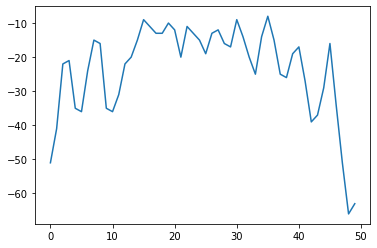

In [27]:
plt.plot([i for i in range(50)],lstm_x[27][:,3])
plt.show()

In [4]:
'''cnn_input'''
raw_data = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    raw_data.append(distribution_matrix)
raw_data = np.array(raw_data)

cnn_x = []
for mat in raw_data:
    cnn_x.append(mat)
cnn_x = np.array(cnn_x)

In [5]:
from keras.models import load_model
from keras import Model
model = load_model('./cnn_0.h5')
model.trainable = False
pred = model.predict(cnn_x)
# pred = model.predict(lstm_x)
# pred = model.predict([cnn_x.reshape(cnn_x.shape[0],cnn_x.shape[1],cnn_x.shape[2],1))
# pred = model.predict([cnn_x,lstm_x])

2021-11-29 16:35:04.556465: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


ValueError: in user code:

    /home/jiay/.local/lib/python3.8/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /home/jiay/.local/lib/python3.8/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jiay/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jiay/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jiay/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jiay/.local/lib/python3.8/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /home/jiay/.local/lib/python3.8/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /home/jiay/.local/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jiay/.local/lib/python3.8/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_44: expected shape=(None, 50, 16), found shape=(None, 200, 200)


In [6]:
print(pred.shape)

(232, 1)


[0.99029684]


In [25]:
error_1 = []
error_0 = []
e_1 = []
e_0 = []
count = 0
for i,p in enumerate(pred):
    if p < 0.5 and labels[i] == 0:
        count += 1
    elif p >= 0.5 and labels[i] == 1:
        count += 1
    elif p < 0.5 and labels[i] == 1:
        error_1.append(round(p[0],2))
        e_1.append(i)
    elif p >= 0.5 and labels[i] == 0:
        error_0.append(round(p[0],2))
        e_0.append(i)

In [26]:
print(count/len(pred))
print(error_1)
print(error_0)
print(e_1)
print(e_0)

0.9655172413793104
[0.02, 0.01, 0.02, 0.04, 0.14, 0.49, 0.02]
[0.9]
[26, 84, 88, 90, 98, 102, 105]
[134]


[0.9994484]
